In [19]:
!pip install wget
!pip install spacy
!pip install gensim

In [20]:
# !wget -O data.csv https://www.dropbox.com/s/xd35vnpmi2f5gdb/2016_US_election_tweets_100k.csv?dl=0
!wget -O data.zip "https://www.dropbox.com/s/szuhoq38fk82u5n/hw2_data.zip?dl=0"
!rm -rf Data_file
!unzip data.zip

--2021-04-09 12:39:04--  https://www.dropbox.com/s/szuhoq38fk82u5n/hw2_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:601f:18::a27d:912, 162.125.9.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:601f:18::a27d:912|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/szuhoq38fk82u5n/hw2_data.zip [following]
--2021-04-09 12:39:05--  https://www.dropbox.com/s/raw/szuhoq38fk82u5n/hw2_data.zip
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb79b32f3f6b4ad658e7d569c49.dl.dropboxusercontent.com/cd/0/inline/BMQn2RfYbl0uAdkyTHWTiHE7tJubAXMrRa2RWfC5xIbu1v8JOowkT_6Eeq8UCHScwH5lQB2OEefPDX8mzdHUZMqmfq3NEb_ARv_4YDWcJ1FQbD9eYYFW9_nzgNC1XNFPE1OGLJPAoAzhC0-3rJWI-B-1/file# [following]
--2021-04-09 12:39:05--  https://ucb79b32f3f6b4ad658e7d569c49.dl.dropboxusercontent.com/cd/0/inline/BMQn2RfYbl0uAdkyTHWTiHE7tJubAXMrRa2RWfC5xIbu1v8JOowkT_6Eeq8UCHScwH5lQ

In [21]:
import multiprocessing

import pandas as pd
pd.set_option('display.max_colwidth', -1)

import spacy

import nltk;
from nltk.corpus import stopwords
nltk.download('stopwords')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import damag
from gensim.models.ldamulticore import LdaMulticore

/home/dipta007/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dipta007/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# dfs = []
# for i in range(1, 6):
#   df = pd.read_csv(f'./Data_file/#longcovid{i}.csv', header=None, names=['data', 'tweet_text'])
#   dfs.append(df)

# df = pd.concat(dfs)

df = pd.read_csv('out_with_lemma.csv')
df.head()

,Unnamed: 0,data,tweet_text
0,0,2020-11-23,back bed pneumonia symptom doctor i appointment tomorrow test gp office home really be gift keep give month infection
1,1,2020-11-23,grade exercise be correct advice
2,2,2020-11-23,second vitamin d clinical trial positive result covid19 longcovid coronavirus
3,3,2020-11-23,graded exercise be advise worryingly say article be bring be completely wrong advice
4,4,2020-11-23,tonight be feature story medical community be now call promise be interesting show


In [23]:
df.head()

,Unnamed: 0,data,tweet_text
0,0,2020-11-23,back bed pneumonia symptom doctor i appointment tomorrow test gp office home really be gift keep give month infection
1,1,2020-11-23,grade exercise be correct advice
2,2,2020-11-23,second vitamin d clinical trial positive result covid19 longcovid coronavirus
3,3,2020-11-23,graded exercise be advise worryingly say article be bring be completely wrong advice
4,4,2020-11-23,tonight be feature story medical community be now call promise be interesting show


In [24]:
len(df)

105821

In [25]:
df['tweet_text'][2]

'second vitamin d clinical trial positive result covid19 longcovid coronavirus'

https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
  
https://github.com/marcmuon/nlp_yelp_review_unsupervised  

## Choose Number of Topics

1. Run LDA on your corpus with different numbers of topics and see if word distribution per topic looks sensible.  
2. Examine the coherence scores of your LDA model, and effectively grid search to choose the highest coherence [4].  
3. Create a handful of LDA models with different topic values, then see how these perform in the supervised classification model training. This is specific to my goals here, since my ultimate aim is to see if the topic distributions have predictive value.

# Pre-Process

In [26]:
mdf = df
df = df.dropna(subset=['tweet_text'])
len(mdf), len(df)

(105821, 105453)

In [27]:
stop_words = stopwords.words('english')
stop_words.extend([
                   "something"
])

!python -m spacy download en_core_web_trf

nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [28]:
def strip_newline(series):
  return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod  

In [29]:
def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    # df['tweet_text'] = df['tweet_text'].apply(lambda x: x.split())
    df['tweet_text'] = strip_newline(df.tweet_text)
    words = list(sent_to_words(df.tweet_text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [30]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(df)


/home/dipta007/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
multiprocessing.cpu_count()

16

In [35]:
def get_model_result(num_topics):
  lda_model = LdaMulticore(corpus=train_corpus4,
                          num_topics=num_topics,
                          id2word=train_id2word4,
                          chunksize=100,
                          workers=multiprocessing.cpu_count(),
                          passes=4,
                          # eval_every = 1
                          )
  coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  return coherence_lda, lda_model

In [36]:
best = 0
best_num = -1
best_model = None
x = []
y = []

for i in range(1, 150, 1):
  curr_val, curr_model = get_model_result(i)
  x.append(i)
  y.append(curr_val)
  if i%10 == 0:
    print(f"Completed {i}")
  if curr_val > best:
    print(f"Found Best Result for {i} with coherence {curr_val}")
    best = curr_val
    best_num = i
    best_model = curr_model

Found Best Result for 1 with coherence 0.1376082244070588
Found Best Result for 2 with coherence 0.2469477808737014
Found Best Result for 3 with coherence 0.2689993291322535
Found Best Result for 6 with coherence 0.2926006085381369
Found Best Result for 7 with coherence 0.3177840845658494
Found Best Result for 8 with coherence 0.3530812145107512
Completed 10
Completed 20
Found Best Result for 20 with coherence 0.36106329690159067
Completed 30
Completed 40
Completed 50
Completed 60
Completed 70
Completed 80
Completed 90
Completed 100
Completed 110
Found Best Result for 114 with coherence 0.36209396822993756
Completed 120
Found Best Result for 128 with coherence 0.3623505663307919
Completed 130
Completed 140


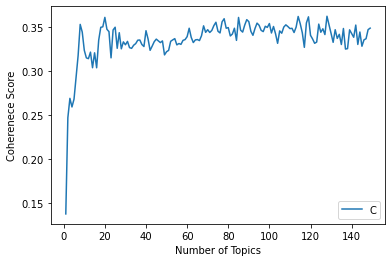

In [37]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.xlabel('Number of Topics')
plt.ylabel('Coherenece Score')
plt.legend('Coherence Values - LDA', loc='best')
plt.savefig('./figs/lda_coherence.png')
plt.show()
# 198


In [39]:
bv, bm = get_model_result(20)

In [40]:
bv

0.33496388393821236

In [41]:
bm.print_topics(20, num_words=20)

[(0,
  '0.195*"get" + 0.045*"let" + 0.045*"know" + 0.044*"child" + 0.043*"ill" + 0.029*"people" + 0.028*"feel" + 0.027*"seem" + 0.026*"well" + 0.024*"kid" + 0.022*"school" + 0.017*"answer" + 0.017*"hard" + 0.017*"go" + 0.016*"affect" + 0.015*"help" + 0.014*"parent" + 0.014*"young" + 0.013*"understand" + 0.012*"think"'),
 (1,
  '0.054*"worrisome" + 0.048*"month" + 0.040*"well" + 0.035*"bad" + 0.023*"organ_damage" + 0.022*"lung" + 0.021*"wave" + 0.020*"longcovid" + 0.019*"work" + 0.019*"longhauler" + 0.019*"still" + 0.017*"later" + 0.014*"normal" + 0.013*"rest" + 0.012*"feel" + 0.011*"flu" + 0.011*"damage" + 0.011*"average" + 0.011*"get" + 0.010*"message"'),
 (2,
  '0.058*"say" + 0.049*"symptom" + 0.031*"fatigue" + 0.030*"people" + 0.028*"also" + 0.026*"post_viral" + 0.018*"care" + 0.017*"condition" + 0.016*"medical" + 0.016*"many" + 0.016*"syndrome" + 0.014*"make" + 0.013*"interview" + 0.013*"develop" + 0.011*"become" + 0.011*"tell" + 0.010*"hope" + 0.009*"linger" + 0.009*"feel" + 0.009

In [49]:
# best_model.print_topics(20, num_words=20)

/home/dipta007/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
set(zip(x, y))

/home/dipta007/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{(1, 0.1376082244070588),
 (2, 0.2469477808737014),
 (3, 0.2689993291322535),
 (4, 0.2592261324295235),
 (5, 0.26810438089813826),
 (6, 0.2926006085381369),
 (7, 0.3177840845658494),
 (8, 0.3530812145107512),
 (9, 0.3443153292398681),
 (10, 0.3235859635152769),
 (11, 0.3150289574391908),
 (12, 0.3141292695462725),
 (13, 0.3215299347583041),
 (14, 0.3038237290966723),
 (15, 0.3207711375102277),
 (16, 0.303742943256972),
 (17, 0.33512072858057224),
 (18, 0.34974568054039934),
 (19, 0.35033618046151754),
 (20, 0.36106329690159067),
 (21, 0.3475408003599065),
 (22, 0.34480976469296004),
 (23, 0.3150402005434722),
 (24, 0.34675130689520745),
 (25, 0.3498655391817334),
 (26, 0.3258966952600399),
 (27, 0.34364901346197496),
 (28, 0.3253130621236005),
 (29, 0.3332060839610965),
 (30, 0.32989695646180217),
 (31, 0.33374770491337896),
 (32, 0.3266495424520961),
 (33, 0.32585287870296137),
 (34, 0.3293959616563284),
 (35, 0.33125378428267144),
 (36, 0.3351448089882815),
 (37, 0.33532786517029634)

In [45]:
# !pip install pyLDAvis

import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(bm, train_corpus4, train_id2word4)



# vis = pyLDAvis.gensim.prepare(bm, train_corpus4, train_id2word4)
vis

/home/dipta007/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()